# Network-Based Spectral Analysis using Pytorch

> V. Choqueuse

The objective of this notebook is to illustrate the benefit of using a deep learning library for parametric spectral estimation.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,fftfreq
from scipy.signal import find_peaks
import torch

## Context

Let us assume a signal composed of $L$ (real-valued) cosine components :

$$x[n]=\sum_{n=0}^{L-1}a_n\cos(\omega_l n+\varphi_n)$$

In parametric analysis, the goal is to estimate the signal parameters, i.e. $\boldsymbol \theta=\{\mathbf{a},\boldsymbol \omega,\boldsymbol\varphi\}$, from $\mathbf{x}=[x[0],\cdots,x[N-1]]$. A classical technique for parameter estimation is based on the Least-Squares (LS) technique. Using the LS technique, the goal is to minimize the following metric

$$\mathcal{J}(\boldsymbol \theta,\mathbf{c})=\|\mathbf{x}-\mathbf{A}(\boldsymbol \omega)\mathbf{c}\|^2$$

where $\mathbf{c}$ is a complex vector depending on $\mathbf{a}$ and $\boldsymbol\varphi$.
This optimization problem can be divided into two steps [(more)](https://epubs.siam.org/doi/abs/10.1137/0710036):

* **Step 1**: Estimation of the angular frequencies $\boldsymbol \omega$ using the Variational Projection approach

$$\widehat{\boldsymbol \omega} =\arg \min_{\boldsymbol \omega} \|\mathbf{P}^{\perp}(\boldsymbol \omega)\mathbf{x}\|^2$$

where $\mathbf{P}^{\perp}(\boldsymbol \omega)=\mathbf{I}_N-\mathbf{A}(\boldsymbol \omega)\mathbf{A}^{\dagger}(\boldsymbol \omega)$ is the orthogonal projector into the noise subspace.

* **Step 2**: LS Estimation of the phasor ($\mathbf{a}$, $\boldsymbol\varphi$).

The first step is the most computational demanding task and is usually performed using the Levenberg-Marquardt algorithm. A classical low-complexity approach for spectral estimation is based on the periodogram. Even if this approach has low computational complexity, it usually suffers from a poor spectral resolution. Other approaches include subspace techniques (MUSIC, ESPRIT).


In this notebook, I show how to estimate the signal parameters using a two-step approach:

* Initialization of the parameters $\boldsymbol \theta=\{\mathbf{a},\boldsymbol \omega,\boldsymbol\varphi\}$ using the low-complexity periodogram technique.
* Refined estimation of the parameters using a Pytorch custom network.

In [38]:
def signal_model(a_list,w_list,phi_list,N_vect,sigma2 = 0):
    L = len(a_list)
    x = np.zeros(len(N_vect))

    for k in range(L):
        x += a_list[k]*np.cos(w_list[k]*N_vect+phi_list[k])

    b = np.sqrt(sigma2)*np.random.randn(len(N_vect))
    x += b
    return x

## Signal Generation

Let us consider the following noisy signal composed of $L=4$ real-valued sine waves.

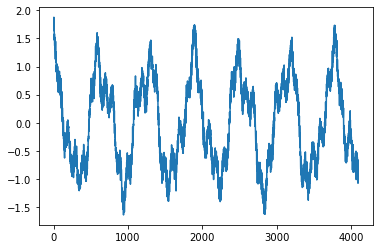

In [33]:
# signal parameter
N = 2**12
L = 4
N_vect = np.arange(N,dtype=np.float64)
a_list = [1,0.3,0.11,0.243]
w_list = [0.01,0.0234,0.033,0.063]
phi_list = [0,-0.2,0,0.4]
sigma2 = 0.01

# generate signal
x = signal_model(a_list,w_list,phi_list,N_vect,sigma2 = sigma2)
plt.plot(x,label="signal");

## Periodogram based spectral Estimation

To estimate the signal parameter, a simple technique is based on the periodogram. First, the angular frequencies are estimated by locating the $L$ peaks of the periodogram. Then, the amplitude and the phase of the sine wave signals are extracted from these $L$ peaks.

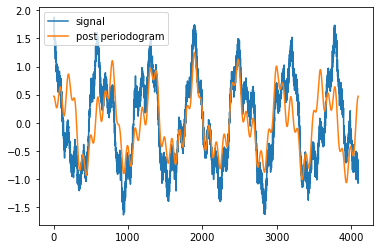

In [34]:
N = len(x)
fft_x = 2*fft(x)/N
freq_list = fftfreq(N)
fft_x_half = fft_x[:int(N/2)]
peaks_locations,_ = find_peaks(np.abs(fft_x_half)**2)

# next only keep the L highest peak
fft_x_peaks_abs = np.abs(fft_x[peaks_locations])
index_sorted = np.argsort(fft_x_peaks_abs)[::-1]
peaks_locations = peaks_locations[index_sorted[:L]]

# compute initial parameters
w_init = 2*np.pi*freq_list[peaks_locations]
c = fft_x_half[peaks_locations]
a_init = np.abs(c)
phi_init = np.angle(c)

x_est = signal_model(a_init,w_init,phi_init,N_vect)

plt.plot(x,label="signal")
plt.plot(x_est,label="post periodogram")
plt.legend();

## Refined Estimation using Pytorch

Let us consider a network with input $\mathbf{N}=[1,2,3,\cdots,N]$. In the following we construct a network composed of 5 layers:

* The first layer performs a multiplication between $\omega_l$ and $\mathbf{N}$ for $l\in \{1,\cdots,L\}$ (input: $N$, output: $L\times N$)
* The second layer add the phase term $\varphi_l$ for $l\in \{1,\cdots,L\}$ (input: $L\times N$, output: $L\times N$)
* The third layer is a non-linear layer that applies the cosine function (input: $L\times N$, output: $L\times N$)
* The fourth layer performs a multiplication between $a_l$ and the output of the previous layer (input: $L\times N$, output: $L\times N$)
* The fifth layer sums the $L$ components (input: $L\times N$, output: $N$)

The output of the network corresponds to the noisy signal $\mathbf{x}$.

In [35]:
class Amp_Net(torch.nn.Module):
    def __init__(self,scale_vect):
        super(Amp_Net, self).__init__()
        self.scale = torch.nn.Parameter(torch.Tensor(scale_vect))

    def forward(self, x):
        scale = self.scale[:, None] 
        y = scale*x
        return y

class Bias_Net(torch.nn.Module):
    def __init__(self,bias_vect):
        super(Bias_Net, self).__init__()
        self.b = torch.nn.Parameter(torch.Tensor(bias_vect))

    def forward(self, x):
        bias = self.b[:, None] 
        y = x + bias
        return y

class Full_Net(torch.nn.Module):

    def __init__(self,a_init,w_init,phi_init):
        super(Full_Net, self).__init__()
        self.amp1 = Amp_Net(w_init)
        self.bias1 = Bias_Net(phi_init)
        self.amp2 = Amp_Net(a_init)

    def forward(self, x):
        x2 = self.amp1(x)         # layer 1: w_l*n_vect (*L)
        x3 = self.bias1(x2)       # layer 2: w_l*n_vect + phi_l (*L)
        x4 = torch.cos(x3)        # layer 3: cos(w_l*n_vect + phi_l) (*L)
        x5 = self.amp2(x4)        # layer 4: a_l cos(w_l*n_vect + phi_l) (*L)
        x6 = torch.sum(x5,dim=0)  # layer 5
        return x6

That's it ! Now, let us improve our periodogram based estimator. 

In [36]:
model = Full_Net(a_init,w_init,phi_init)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_vect_torch = torch.from_numpy(N_vect)
y_torch = torch.from_numpy(x)

for t in range(10000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(n_vect_torch)

    # Compute and print loss
    loss = criterion(y_pred, y_torch)
    if t % 1000 == 0:
        print("it {}: loss={}".format(t, loss.item()/N))

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

it 0: loss=0.2889287013585757
it 1000: loss=0.056737908489258575
it 2000: loss=0.01982654027243922
it 3000: loss=0.011120176718424548
it 4000: loss=0.01104622611810403
it 5000: loss=0.01179303499772676
it 6000: loss=0.01061695134390212
it 7000: loss=0.013578579481015022
it 8000: loss=0.017200750631955718
it 9000: loss=0.01034983082631072


## Reconstructed signal

The following code plots the noisy signal, the reconstructed signal based on the periodogram technique and the reconstructed signal after Pytorch refined estimation. We can observe that the proposed network is able to improve the fitting. As compared to other optimization technique, the proposed methodology is much more flexible, there is no need to compute gradient explicitely. Furthermore, the network can be easily extended to deal with more complex signal model by using custom layer.

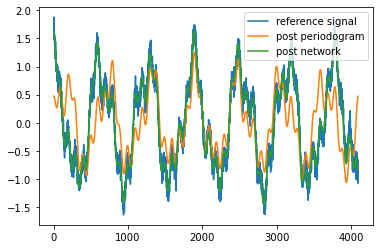

In [37]:
x_est2 = y_pred.detach().numpy()

plt.plot(x,label="reference signal")
plt.plot(x_est,label="post periodogram")
plt.plot(x_est2,label="post network")
plt.legend();

Thank you for reading ! Don't hesitate to contribute.